0. Описать задачу словами +
1. Прочитать данные +
2. Визуализировать данные и вычислить основные характеристики (среднее, разброс, корреляционную матрицу и т.д.). Интерпретировать. +
3. Обработать пропущенные значения (или убедиться, что их нет) +
4. Обработать категориальные признаки +
5. Провести нормализацию (или объяснить, почему в вашем случае она не нужна) +
6. Разбить данные на обучающую и тестовую выборки +
7. Запустить классификатор ближайших соседей (попробовать разное их количество)
8. Вычислить ошибки на обучающей и тестовой выборках. Сделать выводы 
9. По желанию: запустить другие классификаторы. Сравнить результаты
10. По желанию: как-то побороться с несбалансированностью классов (если она есть)
11. По желанию: исключить коррелированные переменные (объяснить зачем)
12. Сделать общие выводы"

# Описание задачи

У компании N есть цель выбрать маркетинговую стратегию для повышения продаж продукта/услуги. Необходимо выявить влияние каждой маркетинговой кампании на определенного потребителя.

Для решения данной задачи были собраны личные данные о потребителях (уровень образования, семейное положение, количество детей, доход), данные о поведении потребителя (траты на покупку определенной продукции, место покупки, жалобы), принятии потребителем определенного предложения (проводимым по пяти разным стратегиям + отдельно по текущей).

Задача сводится к задаче классификации: нужно предсказать, примет ли потребитель текущее предложение (1 - примет, 0 - не примет), в зависимости от определенного покупательского поведения и личных данных.

In [1]:
import numpy as np              # Массивы (матрицы, векторы, линейная алгебра)
import matplotlib.pyplot as plt # Научная графика
%matplotlib inline 
    # Говорим jupyter'у, чтобы весь графический вывод был в браузере, а не в отдельном окне
import pandas as pd             # Таблицы и временные ряды (dataframe, series)
import seaborn as sns           # Еще больше красивой графики для визуализации данных
import sklearn                  # Алгоритмы машинного обучения

# Чтение данных

Увеличим размерность показываемой таблицы для удобства

In [2]:
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 30)

Читаем данные

In [3]:
data_raw = pd.read_csv('marketing_campaign.csv')

In [4]:
data_raw.shape

(2240, 29)

In [5]:
data_raw.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0


In [6]:
data_raw.columns

Index(['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
       'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response'],
      dtype='object')

##### Личные данные
- ID - номер клиента
- Year_Birth - год рождения клиента
- Education - уровень образования клиента
- Marital_Status - семейное положение клиента
- Income - доход клиента
- Kidhome - количество маленьких детей в семье
- Teenhome - количество подростков в семье
- Dt_Customer - дата регистрации клиента
- Recency - количество прошедших дней со дня последней покупки клиента
##### Траты на определенные продукты за 2 года
- MntWines - вино
- MntFruits - фрукты
- MntMeatProducts - мясо
- MntFishProducts - рыба
- MntSweetProducts - сладкое
- MntGoldProds - золотые изделия
##### Поведение потребителя
- NumDealsPurchases - количество покупок со скидкой
- NumWebPurchases - количество покупок через веб-сайт
- NumCatalogPurchases - количество покупок через каталог
- NumStorePurchases - количество покупок, совершенные в магазине
- NumWebVisitsMonth - Количество посещений веб-сайта за последний месяц
##### Ответ на предложения по определенным маркетинговым кампаниям (1 - принял, 0 - не принял)
- AcceptedCmp1
- AcceptedCmp2
- AcceptedCmp3
- AcceptedCmp4
- AcceptedCmp5
##### Жалобы
- Complain - 1, если клиент жаловался в последние 2 года
##### Пока неизвестные признаки
- Z_CostContact - неизвестный признак
- Z_Revenue - неизвестный признак
##### Ответ на текущее предложение
- Response - 1, если клиент принял предложение по последней рекламной акции, иначе 0

#### Приведем к соответствию типы признаков

In [7]:
data_raw.dtypes

ID                       int64
Year_Birth               int64
Education               object
Marital_Status          object
Income                 float64
Kidhome                  int64
Teenhome                 int64
Dt_Customer             object
Recency                  int64
MntWines                 int64
MntFruits                int64
MntMeatProducts          int64
MntFishProducts          int64
MntSweetProducts         int64
MntGoldProds             int64
NumDealsPurchases        int64
NumWebPurchases          int64
NumCatalogPurchases      int64
NumStorePurchases        int64
NumWebVisitsMonth        int64
AcceptedCmp3             int64
AcceptedCmp4             int64
AcceptedCmp5             int64
AcceptedCmp1             int64
AcceptedCmp2             int64
Complain                 int64
Z_CostContact            int64
Z_Revenue                int64
Response                 int64
dtype: object

Категориальные признаки:

In [8]:
data_raw['Education'] = data_raw['Education'].astype('category')
data_raw['Marital_Status'] = data_raw['Marital_Status'].astype('category')
#data_raw['AcceptedCmp1'] = data_raw['AcceptedCmp1'].astype('category')
#data_raw['AcceptedCmp2'] = data_raw['AcceptedCmp2'].astype('category')
#data_raw['AcceptedCmp3'] = data_raw['AcceptedCmp3'].astype('category')
#data_raw['AcceptedCmp4'] = data_raw['AcceptedCmp4'].astype('category')
#data_raw['AcceptedCmp5'] = data_raw['AcceptedCmp5'].astype('category')
#data_raw['Response'] = data_raw['Response'].astype('category')
#data_raw['Complain'] = data_raw['Complain'].astype('category')

Дата:

In [9]:
data_raw['Dt_Customer'] = pd.to_datetime(data_raw['Dt_Customer'])
data_raw['Year_Birth'] = pd.to_datetime(data_raw['Year_Birth'], format="%Y")

In [10]:
data_raw.dtypes

ID                              int64
Year_Birth             datetime64[ns]
Education                    category
Marital_Status               category
Income                        float64
Kidhome                         int64
Teenhome                        int64
Dt_Customer            datetime64[ns]
Recency                         int64
MntWines                        int64
MntFruits                       int64
MntMeatProducts                 int64
MntFishProducts                 int64
MntSweetProducts                int64
MntGoldProds                    int64
NumDealsPurchases               int64
NumWebPurchases                 int64
NumCatalogPurchases             int64
NumStorePurchases               int64
NumWebVisitsMonth               int64
AcceptedCmp3                    int64
AcceptedCmp4                    int64
AcceptedCmp5                    int64
AcceptedCmp1                    int64
AcceptedCmp2                    int64
Complain                        int64
Z_CostContac

Проверим пропущенные значения в датасете.

In [11]:
data_raw.isna().sum()

ID                      0
Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Z_CostContact           0
Z_Revenue               0
Response                0
dtype: int64

In [12]:
data_raw.shape

(2240, 29)

In [13]:
null_value = data_raw.isna().sum()
percent_of_nulls = null_value/data_raw.shape[0]*100

In [14]:
pd.DataFrame({'Missings':null_value, '%': percent_of_nulls})

,Missings,%
ID,0,0.000000
Year_Birth,0,0.000000
Education,0,0.000000
Marital_Status,0,0.000000
Income,24,1.071429
Kidhome,0,0.000000
Teenhome,0,0.000000
Dt_Customer,0,0.000000
Recency,0,0.000000
MntWines,0,0.000000


In [15]:
data_raw.shape

(2240, 29)

Неизвестен доход одного процента людей из выборки. Можем избавиться от этих данных.

In [16]:
data_raw = data_raw.dropna()
data_raw.isna().sum()

ID                     0
Year_Birth             0
Education              0
Marital_Status         0
Income                 0
Kidhome                0
Teenhome               0
Dt_Customer            0
Recency                0
MntWines               0
MntFruits              0
MntMeatProducts        0
MntFishProducts        0
MntSweetProducts       0
MntGoldProds           0
NumDealsPurchases      0
NumWebPurchases        0
NumCatalogPurchases    0
NumStorePurchases      0
NumWebVisitsMonth      0
AcceptedCmp3           0
AcceptedCmp4           0
AcceptedCmp5           0
AcceptedCmp1           0
AcceptedCmp2           0
Complain               0
Z_CostContact          0
Z_Revenue              0
Response               0
dtype: int64

In [17]:
data_raw.shape

(2216, 29)

Посмотрим, какие значения принимают категориальные данные

In [18]:
data_raw['Marital_Status'].value_counts()

Married     857
Together    573
Single      471
Divorced    232
Widow        76
Alone         3
YOLO          2
Absurd        2
Name: Marital_Status, dtype: int64

In [19]:
data_raw['Marital_Status'].replace(to_replace=["Alone", "YOLO", "Absurd"], value=["Single", "Single", "Single"], inplace=True)

Можно заметить, что есть два отдельных признака: Single и Alone, что в целом означает одно и то же. Заменим значения Alone на Single. Ответы "YOLO" и "Absurd" также заменим на "Single", так как их мало и они не несут нам почти никакой информации. Чисто интуитивно их можно отнести к "Single".

In [20]:
data_raw['Marital_Status'].value_counts()

Married     857
Together    573
Single      478
Divorced    232
Widow        76
Name: Marital_Status, dtype: int64

# Визуализация данных

In [21]:
data_raw.describe()

,ID,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
count,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.0,2216.0,2216.000000
mean,5588.353339,52247.251354,0.441787,0.505415,49.012635,305.091606,26.356047,166.995939,37.637635,27.028881,43.965253,2.323556,4.085289,2.671029,5.800993,5.319043,0.073556,0.074007,0.073105,0.064079,0.013538,0.009477,3.0,11.0,0.150271
std,3249.376275,25173.076661,0.536896,0.544181,28.948352,337.327920,39.793917,224.283273,54.752082,41.072046,51.815414,1.923716,2.740951,2.926734,3.250785,2.425359,0.261106,0.261842,0.260367,0.244950,0.115588,0.096907,0.0,0.0,0.357417
min,0.000000,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
25%,2814.750000,35303.000000,0.000000,0.000000,24.000000,24.000000,2.000000,16.000000,3.000000,1.000000,9.000000,1.000000,2.000000,0.000000,3.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
50%,5458.500000,51381.500000,0.000000,0.000000,49.000000,174.500000,8.000000,68.000000,12.000000,8.000000,24.500000,2.000000,4.000000,2.000000,5.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
75%,8421.750000,68522.000000,1.000000,1.000000,74.000000,505.000000,33.000000,232.250000,50.000000,33.000000,56.000000,3.000000,6.000000,4.000000,8.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
max,11191.000000,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,262.000000,321.000000,15.000000,27.000000,28.000000,13.000000,20.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.0,11.0,1.000000


In [22]:
data_raw.describe().shape

(8, 25)

При беглом осмотре можно заключить, что два признака (Z_CostContact и Z_Revenue) для всех строк имеют одно и то же значение: 3 и 11 соответственно. Избавимся от данных, стандартное отклонение которых равняется нулю.

Номер ID не нужен для дальнейшего анализа данных. Уберем признак.

In [23]:
std = data_raw.describe().iloc[2,:]
const_lab = [std[std==0.00].index[0], std[std==0.00].index[1]]
const_lab

['Z_CostContact', 'Z_Revenue']

In [24]:
data_raw.drop(labels=const_lab, axis=1, inplace=True)

In [25]:
data_raw.shape

(2216, 27)

In [26]:
data = data_raw.drop(['ID'], axis=1)

In [27]:
data.describe()

,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response
count,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000
mean,52247.251354,0.441787,0.505415,49.012635,305.091606,26.356047,166.995939,37.637635,27.028881,43.965253,2.323556,4.085289,2.671029,5.800993,5.319043,0.073556,0.074007,0.073105,0.064079,0.013538,0.009477,0.150271
std,25173.076661,0.536896,0.544181,28.948352,337.327920,39.793917,224.283273,54.752082,41.072046,51.815414,1.923716,2.740951,2.926734,3.250785,2.425359,0.261106,0.261842,0.260367,0.244950,0.115588,0.096907,0.357417
min,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,35303.000000,0.000000,0.000000,24.000000,24.000000,2.000000,16.000000,3.000000,1.000000,9.000000,1.000000,2.000000,0.000000,3.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,51381.500000,0.000000,0.000000,49.000000,174.500000,8.000000,68.000000,12.000000,8.000000,24.500000,2.000000,4.000000,2.000000,5.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,68522.000000,1.000000,1.000000,74.000000,505.000000,33.000000,232.250000,50.000000,33.000000,56.000000,3.000000,6.000000,4.000000,8.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,262.000000,321.000000,15.000000,27.000000,28.000000,13.000000,20.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [28]:
data.describe(include=['category'])

,Education
count,2216
unique,5
top,Graduation
freq,1116


Максимум в признаке Income слишком отличается от среднего. Возможно, стоит избавиться от слишком больших значений. Проверим значения кванителей.

In [29]:
data['Income'].quantile([0.005,.01,.05,.1,.5,.9,.95,.99,.995])

0.005      7500.00
0.010      7579.20
0.050     18985.50
0.100     24117.50
0.500     51381.50
0.900     79844.00
0.950     84130.00
0.990     94458.80
0.995    102145.75
Name: Income, dtype: float64

In [30]:
rows_to_drop = data[(data['Income'] < data['Income'].quantile(0.005)) | (data['Income'] > data['Income'].quantile(0.995))].index
data = data.drop(rows_to_drop)
data.shape

(2193, 26)

In [31]:
data.describe()

,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response
count,2193.000000,2193.000000,2193.000000,2193.000000,2193.000000,2193.000000,2193.000000,2193.000000,2193.000000,2193.000000,2193.000000,2193.000000,2193.000000,2193.000000,2193.000000,2193.000000,2193.000000,2193.000000,2193.000000,2193.000000,2193.000000,2193.000000
mean,51769.508892,0.443228,0.506612,49.091199,307.160511,26.438668,165.331509,37.866393,27.011856,43.808482,2.310990,4.080711,2.637939,5.841313,5.302782,0.073871,0.073871,0.072503,0.063383,0.013224,0.009576,0.150479
std,20383.600988,0.537457,0.543775,28.925242,337.541326,39.717524,215.673362,54.817139,40.669711,50.978033,1.825647,2.619821,2.740155,3.217962,2.298142,0.261621,0.261621,0.259379,0.243707,0.114258,0.097409,0.357622
min,7500.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,35523.000000,0.000000,0.000000,24.000000,24.000000,2.000000,16.000000,3.000000,1.000000,9.000000,1.000000,2.000000,0.000000,3.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,51373.000000,0.000000,0.000000,49.000000,179.000000,8.000000,68.000000,12.000000,8.000000,25.000000,2.000000,4.000000,2.000000,5.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,68281.000000,1.000000,1.000000,74.000000,508.000000,33.000000,233.000000,50.000000,34.000000,56.000000,3.000000,6.000000,4.000000,8.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,101970.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,984.000000,259.000000,198.000000,249.000000,15.000000,11.000000,11.000000,13.000000,19.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Можно получить информацию о том, покупатели с каким доходом откликаются на предложения.

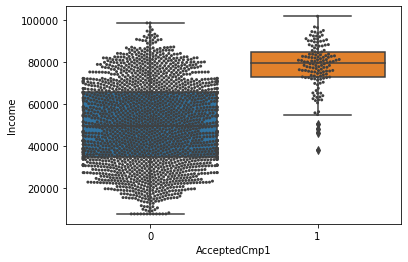

In [32]:
ax1 = sns.boxplot(x="AcceptedCmp1", y="Income", data=data)
ax1 = sns.swarmplot(x="AcceptedCmp1", y="Income", data=data, color=".25", size=3)
ax1
pass

На первую кампанию в основном откликнулись покупатели с доходом более 50 тыс.

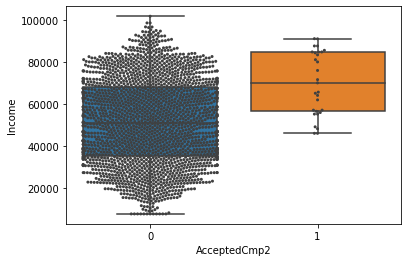

In [33]:
ax2 = sns.boxplot(x="AcceptedCmp2", y="Income", data=data)
ax2 = sns.swarmplot(x="AcceptedCmp2", y="Income", data=data, color=".25", size=3)
ax2
pass

Разброс откликов на вторую компанию не такой большой. Можно также заметить, что на вторую кампанию откликнулось не так уж много покупателей, но те, что откликнулись, это покупатели с доходом выше среднего и несколько ниже максимума.

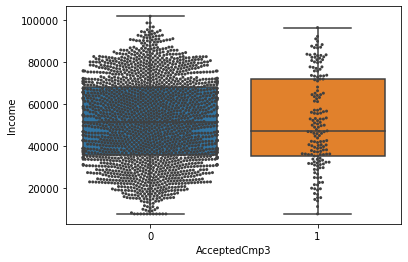

In [34]:
ax3 = sns.boxplot(x="AcceptedCmp3", y="Income", data=data)
ax3 = sns.swarmplot(x="AcceptedCmp3", y="Income", data=data, color=".25", size=3)
ax3
pass

На третью кампанию откликнулись люди с различным доходом.

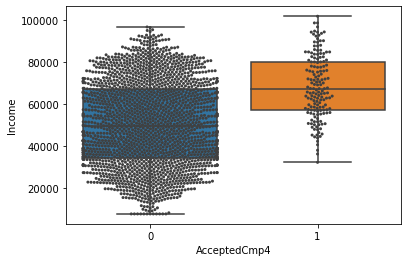

In [35]:
ax4 = sns.boxplot(x="AcceptedCmp4", y="Income", data=data)
ax4 = sns.swarmplot(x="AcceptedCmp4", y="Income", data=data, color=".25", size=3)
ax4
pass

На четвертое предложение откликнулись люди с доходом выше ~30000

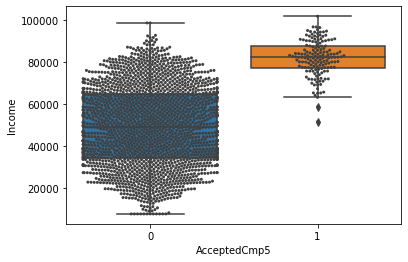

In [36]:
ax5 = sns.boxplot(x="AcceptedCmp5", y="Income", data=data)
ax5 = sns.swarmplot(x="AcceptedCmp5", y="Income", data=data, color=".25", size=3)
ax5
pass

Пятое предложение выбрали более состоятельные покупатели.

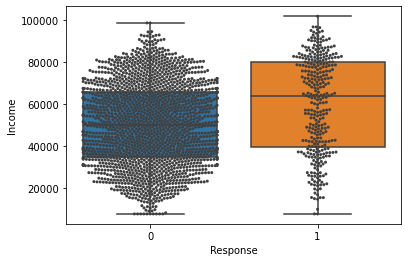

In [37]:
ax6 = sns.boxplot(x="Response", y="Income", data=data)
ax6 = sns.swarmplot(x="Response", y="Income", data=data, color=".25", size=3)
ax6
pass

Текущим предложением воспользовались покупатели с разными уровнями дохода.

In [38]:
corr_mat = data.corr()

In [39]:
corr_mat

,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response
Income,1.000000,-0.541564,0.050270,0.006939,0.735475,0.538359,0.726701,0.553816,0.551541,0.438479,-0.121723,0.522718,0.736067,0.682934,-0.654171,-0.009537,0.228347,0.414132,0.339206,0.103354,-0.031494,0.166192
Kidhome,-0.541564,1.000000,-0.041252,0.011044,-0.501824,-0.375803,-0.457129,-0.391684,-0.381179,-0.357238,0.227691,-0.383761,-0.537166,-0.512188,0.473395,0.013617,-0.161584,-0.204445,-0.172785,-0.080631,0.040888,-0.076582
Teenhome,0.050270,-0.041252,1.000000,0.009823,0.003817,-0.176259,-0.268182,-0.206316,-0.161484,-0.026483,0.413352,0.161504,-0.110452,0.051699,0.137120,-0.045123,0.041460,-0.189384,-0.142585,-0.012422,0.003110,-0.152913
Recency,0.006939,0.011044,0.009823,1.000000,0.014224,-0.003708,0.026238,-0.000034,0.030722,0.023463,-0.001358,0.000746,0.031164,-0.001432,-0.018156,-0.034469,0.019365,0.001915,-0.018747,0.004328,0.013453,-0.200757
MntWines,0.735475,-0.501824,0.003817,0.014224,1.000000,0.384018,0.604406,0.393023,0.394467,0.400141,0.018906,0.582617,0.689752,0.637721,-0.335291,0.061647,0.373749,0.472985,0.349412,0.211552,-0.040256,0.242131
MntFruits,0.538359,-0.375803,-0.176259,-0.003708,0.384018,1.000000,0.579295,0.591455,0.578070,0.399245,-0.135874,0.315451,0.523630,0.452807,-0.438265,0.015144,0.000436,0.203406,0.181504,-0.022691,-0.005567,0.114060
MntMeatProducts,0.726701,-0.457129,-0.268182,0.026238,0.604406,0.579295,1.000000,0.606585,0.572752,0.394651,-0.195214,0.358980,0.707458,0.528120,-0.562033,0.022819,0.096531,0.398183,0.331070,0.042031,-0.024103,0.251843
MntFishProducts,0.553816,-0.391684,-0.206316,-0.000034,0.393023,0.591455,0.606585,1.000000,0.592618,0.434060,-0.145458,0.313602,0.575952,0.453535,-0.468052,-0.000234,0.014049,0.191366,0.257570,0.002322,-0.021717,0.102745
MntSweetProducts,0.551541,-0.381179,-0.161484,0.030722,0.394467,0.578070,0.572752,0.592618,1.000000,0.369605,-0.118419,0.327764,0.540641,0.459361,-0.440761,0.003048,0.017454,0.253215,0.238256,-0.003666,-0.022945,0.109628
MntGoldProds,0.438479,-0.357238,-0.026483,0.023463,0.400141,0.399245,0.394651,0.434060,0.369605,1.000000,0.075913,0.395393,0.494485,0.398730,-0.260202,0.130018,0.021517,0.178183,0.166110,0.044922,-0.031510,0.138311


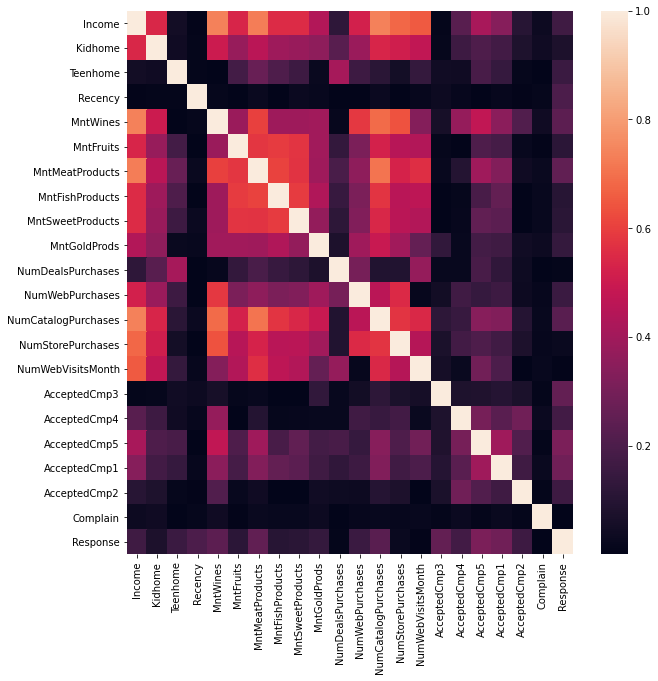

In [40]:
plt.figure(figsize=(10,10))
sns.heatmap(abs(corr_mat))
pass

Корреляция между определенными признаками и принятием какого-либо коммерческого предложения небольшая, однако наблюдается корреляция между доходом и покупаемыми продуктами, между продуктами и способом покупки.

In [41]:
corr_mat > 0.5

,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response
Income,True,False,False,False,True,True,True,True,True,False,False,True,True,True,False,False,False,False,False,False,False,False
Kidhome,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
Teenhome,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
Recency,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
MntWines,True,False,False,False,True,False,True,False,False,False,False,True,True,True,False,False,False,False,False,False,False,False
MntFruits,True,False,False,False,False,True,True,True,True,False,False,False,True,False,False,False,False,False,False,False,False,False
MntMeatProducts,True,False,False,False,True,True,True,True,True,False,False,False,True,True,False,False,False,False,False,False,False,False
MntFishProducts,True,False,False,False,False,True,True,True,True,False,False,False,True,False,False,False,False,False,False,False,False,False
MntSweetProducts,True,False,False,False,False,True,True,True,True,False,False,False,True,False,False,False,False,False,False,False,False,False
MntGoldProds,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False


In [42]:
corr_mat.where(np.triu(corr_mat > 0.5, k=1)).stack().sort_values(ascending=False)

Income               NumCatalogPurchases    0.736067
                     MntWines               0.735475
                     MntMeatProducts        0.726701
MntMeatProducts      NumCatalogPurchases    0.707458
MntWines             NumCatalogPurchases    0.689752
Income               NumStorePurchases      0.682934
MntWines             NumStorePurchases      0.637721
MntMeatProducts      MntFishProducts        0.606585
MntWines             MntMeatProducts        0.604406
MntFishProducts      MntSweetProducts       0.592618
MntFruits            MntFishProducts        0.591455
MntWines             NumWebPurchases        0.582617
MntFruits            MntMeatProducts        0.579295
                     MntSweetProducts       0.578070
MntFishProducts      NumCatalogPurchases    0.575952
NumCatalogPurchases  NumStorePurchases      0.575008
MntMeatProducts      MntSweetProducts       0.572752
Income               MntFishProducts        0.553816
                     MntSweetProducts       0.

Видна зависимость количества покупок от уровня дохода, а также количество купленных продуктов одной категории от количества купленных продуктов другой категории.


# Бинаризация номинальных признаков

В датасете присутствуют два категориальных признака: Marital_Status и Education

In [43]:
Education_dummies = pd.get_dummies(data['Education'])

In [44]:
Education_dummies.head()

,2n Cycle,Basic,Graduation,Master,PhD
0,0,0,1,0,0
1,0,0,1,0,0
2,0,0,1,0,0
3,0,0,1,0,0
4,0,0,0,0,1


In [45]:
data_test = pd.concat((data, Education_dummies), axis=1)
data_test.drop(['Education'], axis=1, inplace=True)

In [46]:
data_test

,Year_Birth,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,2n Cycle,Basic,Graduation,Master,PhD
0,1957-01-01,Single,58138.0,0,0,2012-09-04,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,1,0,0,1,0,0
1,1954-01-01,Single,46344.0,1,1,2014-03-08,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,0,0,0,1,0,0
2,1965-01-01,Together,71613.0,0,0,2013-08-21,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,0,0,0,1,0,0
3,1984-01-01,Together,26646.0,1,0,2014-02-10,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,0,0,0,1,0,0
4,1981-01-01,Married,58293.0,1,0,2014-01-19,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,1967-01-01,Married,61223.0,0,1,2013-06-13,46,709,43,182,42,118,247,2,9,3,4,5,0,0,0,0,0,0,0,0,0,1,0,0
2236,1946-01-01,Together,64014.0,2,1,2014-06-10,56,406,0,30,0,0,8,7,8,2,5,7,0,0,0,1,0,0,0,0,0,0,0,1
2237,1981-01-01,Divorced,56981.0,0,0,2014-01-25,91,908,48,217,32,12,24,1,2,3,13,6,0,1,0,0,0,0,0,0,0,1,0,0
2238,1956-01-01,Together,69245.0,0,1,2014-01-24,8,428,30,214,80,30,61,2,6,5,10,3,0,0,0,0,0,0,0,0,0,0,1,0


In [47]:
Mstatus_dummies = pd.get_dummies(data_test['Marital_Status'])
Mstatus_dummies.head()

,Divorced,Married,Single,Together,Widow
0,0,0,1,0,0
1,0,0,1,0,0
2,0,0,0,1,0
3,0,0,0,1,0
4,0,1,0,0,0


In [48]:
data_test = pd.concat((data_test, Mstatus_dummies), axis=1)
data_test.drop(['Marital_Status'], axis=1, inplace=True)
data_test.head()

,Year_Birth,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,...,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,2n Cycle,Basic,Graduation,Master,PhD,Divorced,Married,Single,Together,Widow
0,1957-01-01,58138.0,0,0,2012-09-04,58,635,88,546,172,88,88,3,8,10,...,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0
1,1954-01-01,46344.0,1,1,2014-03-08,38,11,1,6,2,1,6,2,1,1,...,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
2,1965-01-01,71613.0,0,0,2013-08-21,26,426,49,127,111,21,42,1,8,2,...,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
3,1984-01-01,26646.0,1,0,2014-02-10,26,11,4,20,10,3,5,2,2,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
4,1981-01-01,58293.0,1,0,2014-01-19,94,173,43,118,46,27,15,5,5,3,...,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0


# Нормализация количественных признаков

In [49]:
data_stand = data_test.drop(['Dt_Customer', 'Year_Birth'], axis=1)

In [50]:
data_stand = (data_stand - data_stand.mean(axis = 0))/data_stand.std(axis = 0)

In [51]:
data_stand.describe()

,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,...,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,2n Cycle,Basic,Graduation,Master,PhD,Divorced,Married,Single,Together,Widow
count,2.193000e+03,2.193000e+03,2.193000e+03,2.193000e+03,2.193000e+03,2.193000e+03,2.193000e+03,2.193000e+03,2.193000e+03,2.193000e+03,2.193000e+03,2.193000e+03,2.193000e+03,2.193000e+03,2.193000e+03,...,2.193000e+03,2.193000e+03,2.193000e+03,2.193000e+03,2.193000e+03,2.193000e+03,2.193000e+03,2.193000e+03,2.193000e+03,2.193000e+03,2.193000e+03,2.193000e+03,2.193000e+03,2.193000e+03,2.193000e+03
mean,2.064044e-16,-5.832088e-17,3.199548e-17,6.039654e-17,4.126000e-17,8.657006e-17,-3.756432e-17,2.025031e-19,-3.341300e-17,-2.374348e-17,1.222612e-17,3.680493e-16,-3.660243e-17,1.275769e-16,-1.191731e-16,...,1.231725e-16,-2.855799e-16,2.483320e-16,-2.622288e-16,3.892109e-16,-2.608239e-16,3.247390e-16,1.593699e-16,2.458640e-16,3.375726e-16,-4.288002e-17,6.976230e-17,9.406267e-17,1.964280e-17,1.625846e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-2.171820e+00,-8.246766e-01,-9.316581e-01,-1.697175e+00,-9.099938e-01,-6.656676e-01,-7.665829e-01,-6.907765e-01,-6.641762e-01,-8.593600e-01,-1.265847e+00,-1.557630e+00,-9.626969e-01,-1.815221e+00,-2.307421e+00,...,-2.795272e-01,-2.600807e-01,-1.157368e-01,-9.830615e-02,-4.207765e-01,-3.167104e-01,-1.588519e-01,-1.007552e+00,-4.452754e-01,-5.228713e-01,-3.405549e-01,-7.953759e-01,-5.249914e-01,-5.889765e-01,-1.894294e-01
25%,-7.970382e-01,-8.246766e-01,-9.316581e-01,-8.674499e-01,-8.388914e-01,-6.153120e-01,-6.923966e-01,-6.360491e-01,-6.395879e-01,-6.828134e-01,-7.180960e-01,-7.942188e-01,-9.626969e-01,-8.829542e-01,-1.002019e+00,...,-2.795272e-01,-2.600807e-01,-1.157368e-01,-9.830615e-02,-4.207765e-01,-3.167104e-01,-1.588519e-01,-1.007552e+00,-4.452754e-01,-5.228713e-01,-3.405549e-01,-7.953759e-01,-5.249914e-01,-5.889765e-01,-1.894294e-01
50%,-1.945235e-02,-8.246766e-01,-9.316581e-01,-3.152930e-03,-3.796884e-01,-4.642452e-01,-4.512913e-01,-4.718669e-01,-4.674697e-01,-3.689527e-01,-1.703448e-01,-3.080796e-02,-2.328112e-01,-2.614429e-01,3.033835e-01,...,-2.795272e-01,-2.600807e-01,-1.157368e-01,-9.830615e-02,-4.207765e-01,-3.167104e-01,-1.588519e-01,9.920516e-01,-4.452754e-01,-5.228713e-01,-3.405549e-01,-7.953759e-01,-5.249914e-01,-5.889765e-01,-1.894294e-01
75%,8.100380e-01,1.035936e+00,9.073394e-01,8.611441e-01,5.950071e-01,1.651999e-01,3.137545e-01,2.213470e-01,1.718267e-01,2.391524e-01,3.774063e-01,7.326028e-01,4.970744e-01,6.708241e-01,7.385176e-01,...,-2.795272e-01,-2.600807e-01,-1.157368e-01,-9.830615e-02,-4.207765e-01,-3.167104e-01,-1.588519e-01,9.920516e-01,-4.452754e-01,-5.228713e-01,-3.405549e-01,1.256694e+00,-5.249914e-01,1.697086e+00,-1.894294e-01
max,2.462788e+00,2.896549e+00,2.746337e+00,1.725441e+00,3.513168e+00,4.344715e+00,3.795872e+00,4.034023e+00,4.204312e+00,4.025097e+00,6.950419e+00,2.641130e+00,3.051674e+00,2.224602e+00,5.960127e+00,...,3.575838e+00,3.843207e+00,8.636357e+00,1.016766e+01,2.375475e+00,3.156019e+00,6.292301e+00,9.920516e-01,2.244777e+00,1.911644e+00,2.935045e+00,1.256694e+00,1.903925e+00,1.697086e+00,5.276605e+00


# Отбор признаков

In [67]:
X = data_stand.drop('Response', axis = 1) # выбрасываем столбец 'Response'
y = data_stand['Response']
feature_names = X.columns

0       2.375475
1      -0.420777
2      -0.420777
3      -0.420777
4      -0.420777
          ...   
2235   -0.420777
2236   -0.420777
2237   -0.420777
2238   -0.420777
2239    2.375475
Name: Response, Length: 2193, dtype: float64

In [53]:
type(feature_names)

pandas.core.indexes.base.Index

In [54]:
feature_names

Index(['Income', 'Kidhome', 'Teenhome', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', '2n Cycle', 'Basic', 'Graduation', 'Master',
       'PhD', 'Divorced', 'Married', 'Single', 'Together', 'Widow'],
      dtype='object')

In [55]:
X = X.to_numpy()

In [69]:
y = np.array(y, dtype='int')

In [70]:
y

array([2, 0, 0, ..., 0, 0, 2])

In [58]:
print(X.shape)
print(y.shape)
N, d = X.shape

(2193, 31)
(2193,)


In [59]:
type(X)

numpy.ndarray

In [60]:
type(y)

numpy.ndarray

In [61]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

N_train, _ = X_train.shape 
N_test,  _ = X_test.shape 

print(N_train, N_test)

1535 658


# Метод kNN

In [62]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 10)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=10)

In [63]:
y_test_predict = knn.predict(X_test)
y_train_predict = knn.predict(X_train)
err_test  = np.mean(y_test  != y_test_predict)
err_train = np.mean(y_train != y_train_predict)
print(err_train, err_test)

0.12638436482084692 0.1276595744680851


In [64]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_test_predict))
print(classification_report(y_test, y_test_predict))

[[554   4]
 [ 80  20]]
              precision    recall  f1-score   support

           0       0.87      0.99      0.93       558
           2       0.83      0.20      0.32       100

    accuracy                           0.87       658
   macro avg       0.85      0.60      0.63       658
weighted avg       0.87      0.87      0.84       658

